In [30]:
from torch.utils.data import Dataset
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from sklearn import decomposition
import torch.nn.functional as F
import seaborn as sns
from random import randint
from augment_functions import random_mask, resize_encoder, augment_sample, augment_sample_random_mask, resize_to_orig

In [31]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [32]:
class WeatherBenchDataset(Dataset):
    def __init__(self, data, mask_prob=0.7):
        self.data = data
        self.mask_prob = mask_prob
        
    def __len__(self):
        return (self.data.shape[0])

    def __getitem__(self, idx):
        x_orig = self.data[idx]
        x = resize_encoder(x_orig)
        masked_x = random_mask(x, mask_prob=self.mask_prob)
        y = idx
        x_aug = augment_sample(x_orig)
        x_prime = augment_sample_random_mask(x_orig, random_mask_prob=self.mask_prob)
        return x_orig, x, masked_x, y, x_aug, x_prime

In [ ]:
model = torch.load('simclr_decoder.pth', weights_only=False, map_location=DEVICE)
model.eval()

model_encoder = model.model.encoder
model_decoder = model.decoder

BATCH_SIZE = 100
data = torch.load('/vol/bitbucket/nb324/ERA5_64x32_daily_850.pt')
n_samples = data.shape[0]
n_train = int(n_samples * 0.6)
n_valid = int(n_samples * 0.2)
train_data = data[:n_train]
valid_data = data[n_train:n_train+n_valid]
test_data = data[n_train+n_valid:]

mean = train_data.mean(dim=(0, 2, 3), keepdim=True)
std = train_data.std(dim=(0, 2, 3), keepdim=True)

test_data = (test_data - mean) / std
test_dataset = WeatherBenchDataset(data=test_data, mask_prob=0.7)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_data = (train_data - mean) / std
train_dataset = WeatherBenchDataset(data=train_data, mask_prob=0.7)
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [34]:
# Grab a batch
batch = list(testloader)[0]

batch = next(iter(testloader))

x_orig = batch[0].to(DEVICE)
x = batch[1].to(DEVICE)
masked_x = batch[2].to(DEVICE)
y = batch[3].to(DEVICE)

print(x.shape)


torch.Size([100, 5, 144, 72])


In [35]:
with torch.no_grad():
    _, recon_x = model(x)
    _, recon_masked_x = model(masked_x)

print(F.mse_loss(recon_masked_x, x_orig))
print(F.mse_loss(recon_x, x_orig))

tensor(0.1143)
tensor(0.1242)


In [36]:
# Grab a batch
batch = list(testloader)[0]

batch = next(iter(testloader))

x_orig = batch[0][0].unsqueeze(0).to(DEVICE)
x = batch[1][0].unsqueeze(0).to(DEVICE)
masked_x = batch[2][0].unsqueeze(0).to(DEVICE)
y = batch[3].to(DEVICE)

print(x.shape)

torch.Size([1, 5, 144, 72])


In [37]:
with torch.no_grad():
    z, _ = model_encoder(x)
    recon_x = model_decoder(z)
    z, _ = model_encoder(masked_x)
    recon_masked_x = model_decoder(z)

In [38]:
print(recon_x.shape)
x_temp = x[:, 0, :, :].unsqueeze(1).squeeze(0).permute(1,2,0).cpu().numpy()
recon_x_temp = recon_x[:, 0, :, :].unsqueeze(1).squeeze(0).permute(1,2,0).cpu().numpy()

masked_x_temp = masked_x[:, 0, :, :].unsqueeze(1).squeeze(0).permute(1,2,0).cpu().numpy()
recon_masked_x_temp = recon_masked_x[:, 0, :, :].unsqueeze(1).squeeze(0).permute(1,2,0).cpu().numpy()

x_orig_temp = x_orig[:, 0, :, :].unsqueeze(1).squeeze(0).permute(1,2,0).cpu().numpy()

print(F.mse_loss(recon_masked_x, x_orig))
print(F.mse_loss(recon_x, x_orig))


torch.Size([1, 5, 64, 32])
tensor(0.0944)
tensor(0.1029)


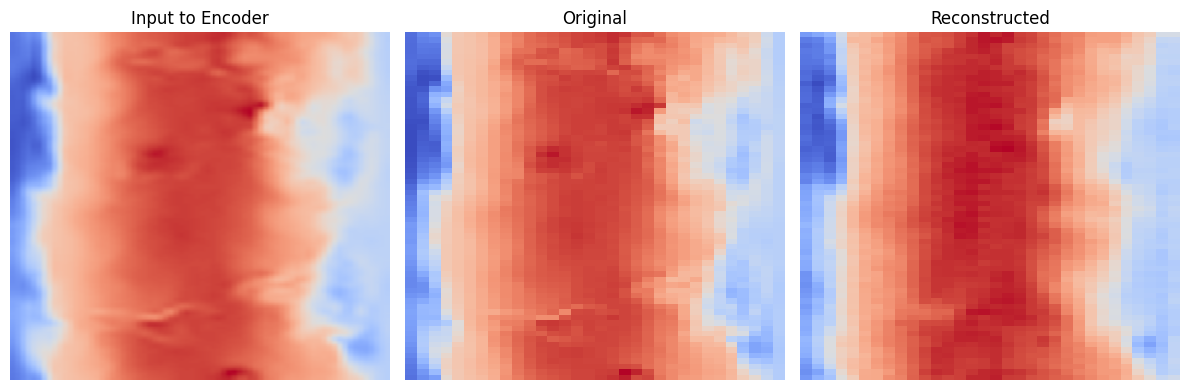

In [39]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(x_temp, cmap='coolwarm', aspect='auto')
axs[0].set_title('Input to Encoder')
axs[0].axis('off')

axs[1].imshow(x_orig_temp, cmap='coolwarm', aspect='auto')
axs[1].set_title('Original')
axs[1].axis('off')

axs[2].imshow(recon_x_temp, cmap='coolwarm', aspect='auto')
axs[2].set_title('Reconstructed')
axs[2].axis('off')

plt.tight_layout()
plt.show()

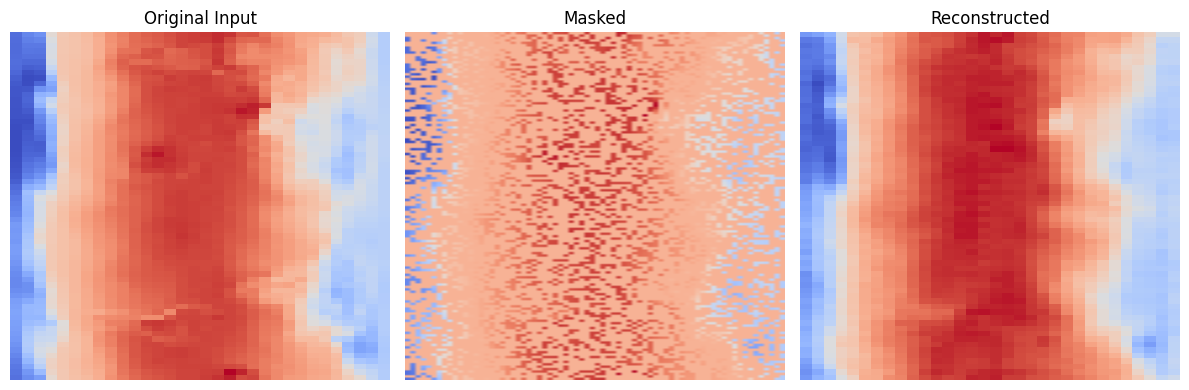

In [40]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(x_orig_temp, cmap='coolwarm', aspect='auto')
axs[0].set_title('Original Input')
axs[0].axis('off')

axs[1].imshow(masked_x_temp, cmap='coolwarm', aspect='auto')
axs[1].set_title('Masked')
axs[1].axis('off')

axs[2].imshow(recon_masked_x_temp, cmap='coolwarm', aspect='auto')
axs[2].set_title('Reconstructed')
axs[2].axis('off')

plt.tight_layout()
plt.show()